In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D # for a compact legend

In [ ]:
Ecoli_mat = np.genfromtxt('EcoliRSCU.mat.csv', delimiter=',')

In [15]:
print ("Ecoli matrix shape: ", Ecoli_mat.shape)

Ecoli matrix shape:  (4243, 59)


In [16]:
Ecoli_labels = np.genfromtxt('EcoliRSCU.label.csv', delimiter=',')
print ("Ecoli labels: ", Ecoli_labels.shape)

Ecoli labels:  (4243,)


### 1.  What is **RSCU**?

**Relative Synonymous Codon Usage (RSCU)** measures, for every synonymous codon,  
how often it is used **relative to the expectation that all synonymous codons for the same amino-acid family are used equally**.

$$\mathrm{RSCU}_{ij}
   \;=\;
   \frac{x_{ij}}
        {\tfrac{1}{n_i}\displaystyle\sum_{j=1}^{n_i} x_{ij}}
$$
* $(x_{ij})$: count of codon *j* for amino-acid family *i*  
* $(n_i)$: number of synonymous codons for that amino acid  
If all codons were chosen at random, **RSCU = 1**.  
Values ≪ 1 indicate under-representation, values ≫ 1 indicate preference [1].

---

### 2.  Why does each gene vector have **59 values**?

| Step | Count |
|------|-------|
| Total genetic-code triplets | 64 |
| − Stop codons (UAA, UAG, UGA) | − 3 |
| − Unique sense codons (AUG for Met, UGG for Trp) | − 2 |
| **Informative codons** | **59** |

Met and Trp each have only one codon, so their RSCU is always 1 and adds no information.  
Consequently, codon-usage analyses (PCA, CA, etc.) use a 59-dimensional space [2].

---

### 3.  “Alien” genes & genomic islands

* **Genomic islands (GIs)** are DNA blocks (≈10–200 kb) imported by horizontal gene transfer.  
  They often encode virulence factors, antibiotic resistance or metabolic modules and differ from the host genome in GC-content, oligonucleotide composition **and codon usage** [3].
* **Alien genes** are the individual ORFs whose composition diverges strongly enough for tools such as **SIGI-HMM** to flag them as horizontally acquired based solely on codon-usage scores [4].

---

### 4.  Why do highly expressed (ribosomal-protein) genes show a distinctive codon usage?

1. **tRNA adaptation / translational efficiency** — they bias toward “optimal” codons matching the most abundant tRNA species, speeding elongation and reducing errors [5].  
2. **Proteome-wide resource economy** — fast decoding frees ribosomes and tRNAs for other transcripts, raising global growth rate [6].  
3. **mRNA structure & stability** — choice of codons modulates local RNA secondary structure, influencing initiation, elongation and co-translational folding.

Because the rest of the genome is governed by different pressures (mutation bias, occasional HGT), ribosomal genes (label 2 in the dataset) occupy a clearly separated cluster in any dimensionality-reduction of the 59-D RSCU space.

---

### Sources  

1. Sharp & Li (1986) *Nucleic Acids Res.*; concise overview at <https://www.lirmm.fr/~rivals/rscu/>  
2. Zhang et al. (2014) *BMC Genomics* — correspondence-analysis with **59** codons (Met, Trp, stops excluded); PMC 4268816  
3. Zhang & Ye (2016) *Computational Methods for Predicting Genomic Islands*; doi:10.1016/S2001-0370(16)30004-6  
4. Waack et al. (2006) “SIGI: score-based identification of genomic islands”; PMC 394314  
5. Hanson & Coller (2018) “Codon optimality, bias and usage in translation and mRNA decay”; PMC 6594389  
6. Frumkin et al. (2018) “Codon usage of highly expressed genes affects proteome-wide translation efficiency”; PNAS 115 E4940 (doi:10.1073/pnas.1719375115)


In [17]:
def power_method(Ecoli_mat, n_evs, tol=1e-10, max_iter=100):
    """
    Computing several eigenvectors without np.linalg.eig

    Parameters:
    x_data_mat : The data matrix (rows = samples), assumed already mean‐centered or we will center it inside the function.
    n_evs : Number of leading eigen values/vecs to calculate.
    tol : Convergence tolerance on ||v_new - v_old||.
    max_iter : Maximum number of inner iterations.

    Returns:
    eigvals : The leading eigenvalues in descending order.
    eigvecs : Corresponding eigenvectors.
    """
    # centering the data
    X = Ecoli_mat - Ecoli_mat.mean(axis=0, keepdims=True)
    # initial covariance
    C = np.cov(X, bias=True, rowvar=False)

    eigvals_arr = [] # shape is (n_evs, )
    eigvecs_arr = [] # shape is (n_evs, n_dims)

    for k in range(n_evs):
        # random initial unit vector
        v = np.random.randn(C.shape[0])
        v /= np.linalg.norm(v)

        # power method on current C
        for i in range(max_iter):
            w     = C @ v
            lambda_   = np.linalg.norm(w)
            v_new = w / lambda_

            # checking convergence
            if np.linalg.norm(v_new - v) < tol:
                break
            v = v_new

        # storing the converged eigenpair
        eigvals_arr.append(lambda_)
        eigvecs_arr.append(v_new.copy())

        # removing the found component
        C = C - lambda_ * np.outer(v_new, v_new)

    return np.array(eigvals_arr), np.vstack(eigvecs_arr)

≥70 % var with  18 components
≥90 % var with  32 components


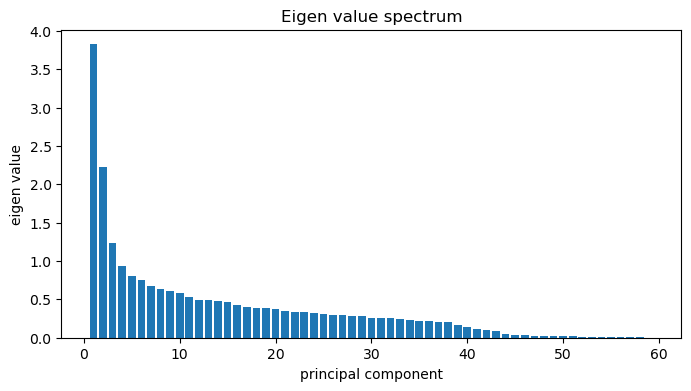

In [18]:
eigvals, eigvecs = power_method(Ecoli_mat, n_evs = 59, tol=1e-8, max_iter=100)

# Sorting the eigvalues
order = np.argsort(eigvals)[::-1]
eigvals, eigvecs = eigvals[order], eigvecs[order]

# Explain variance spectrum
explained_var = eigvals / eigvals.sum()
cum_var = np.cumsum(explained_var)


fig, ax = plt.subplots(figsize=(8,4))
ax.bar(np.arange(1,60), eigvals[:59])
ax.set_xlabel('principal component')
ax.set_ylabel('eigen value')
ax.set_title('Eigen value spectrum')

# number of PCs for >= 70 % / >= 90 %
n70 = np.searchsorted(cum_var, 0.70) + 1
n90 = np.searchsorted(cum_var, 0.90) + 1
print(f'≥70 % var with  {n70} components')
print(f'≥90 % var with  {n90} components')

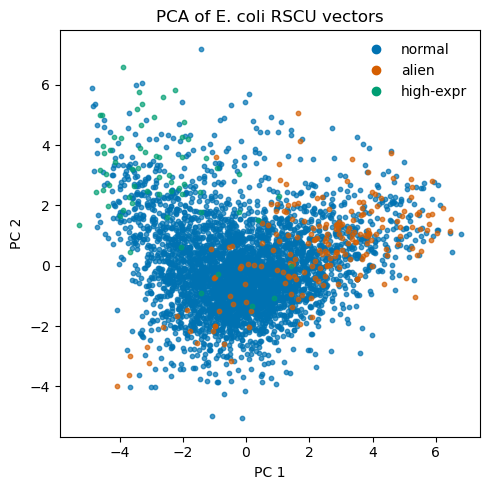

In [19]:
# Projecting Data onto first two PCs
Xc = Ecoli_mat - Ecoli_mat.mean(axis=0, keepdims=True)
Z  = Xc @ eigvecs[:2].T      # shape: (n_genes, 2)

# Scatter colored by label
label_names = {0:'normal', 1:'alien', 2:'high-expr'}
colors = {0:'#0072B2', 1:'#D55E00', 2:'#009E73'}

fig, ax = plt.subplots(figsize=(5,5))
for lab in np.unique(Ecoli_labels):
    ax.scatter(Z[Ecoli_labels==lab,0],
               Z[Ecoli_labels==lab,1],
               c=colors[lab], s=10, alpha=0.7)

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_title('PCA of E. coli RSCU vectors')

# compact legend
legend_elems = [Line2D([0],[0], marker='o', linestyle='',
                       color=colors[lab], label=label_names[lab])
                for lab in label_names]
ax.legend(handles=legend_elems, frameon=False, loc='best')
plt.tight_layout()

In [20]:
Bsub_mat = np.genfromtxt ('BsubRSCU.mat.csv', delimiter=',')
Bsub_labels = np.genfromtxt ('BsubRSCU.label.csv', delimiter=',')

≥70 % var with  20 components
≥90 % var with  34 components


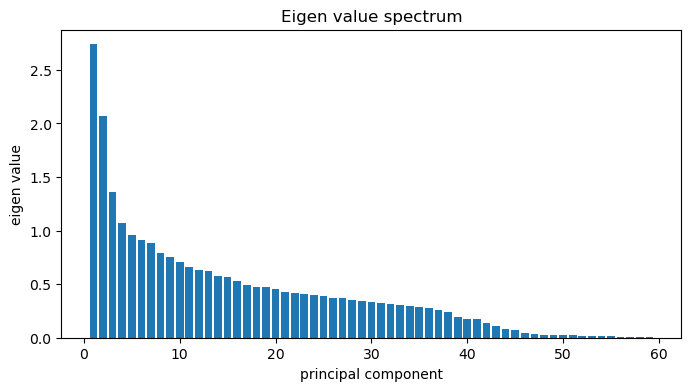

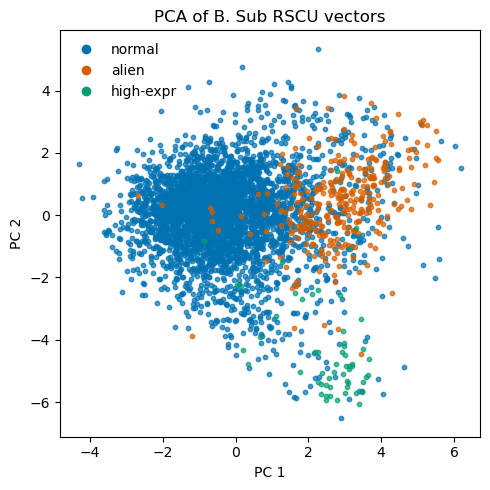

In [21]:
eigvals, eigvecs = power_method(Bsub_mat, n_evs = 59, tol=1e-8, max_iter=100)

# Sorting the eigvalues
order = np.argsort(eigvals)[::-1]
eigvals, eigvecs = eigvals[order], eigvecs[order]

# Explain variance spectrum
explained_var = eigvals / eigvals.sum()
cum_var = np.cumsum(explained_var)


fig, ax = plt.subplots(figsize=(8,4))
ax.bar(np.arange(1,60), eigvals[:59])
ax.set_xlabel('principal component')
ax.set_ylabel('eigen value')
ax.set_title('Eigen value spectrum')

# number of PCs for >= 70 % / >= 90 %
n70 = np.searchsorted(cum_var, 0.70) + 1
n90 = np.searchsorted(cum_var, 0.90) + 1
print(f'≥70 % var with  {n70} components')
print(f'≥90 % var with  {n90} components')

# Projecting Data onto first two PCs
Xc = Bsub_mat - Bsub_mat.mean(axis=0, keepdims=True)
Z  = Xc @ eigvecs[:2].T      # shape: (n_genes, 2)

# Scatter colored by label
label_names = {0:'normal', 1:'alien', 2:'high-expr'}
colors = {0:'#0072B2', 1:'#D55E00', 2:'#009E73'}

fig, ax = plt.subplots(figsize=(5,5))
for lab in np.unique(Bsub_labels):
    ax.scatter(Z[Bsub_labels==lab,0],
               Z[Bsub_labels==lab,1],
               c=colors[lab], s=10, alpha=0.7)

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_title('PCA of B. Sub RSCU vectors')

# compact legend
legend_elems = [Line2D([0],[0], marker='o', linestyle='',
                       color=colors[lab], label=label_names[lab])
                for lab in label_names]
ax.legend(handles=legend_elems, frameon=False, loc='best')
plt.tight_layout()

### Task 2: Multidimensional Scaling

In [22]:
Dmat1 = np.load('distance_mat1.npy')
Dmat2 = np.load('distance_mat2.npy')

In [23]:
print("number of genes in Distance matrix 1: ",len(Dmat1))
print("number of genes in Distance matrix 2: ",len(Dmat2))

number of genes in Distance matrix 1:  4243
number of genes in Distance matrix 2:  4105


#### For large, dense numeric arrays like pairwise-distance matrices, a compact binary container is smaller, faster, loss-free and less error prone than a human readable CSV.

In [2]:
import numpy as np

def metric_mds(D, n_components: int = 2):
    """
    Metric multidimensional scaling (MDS).

    Parameters
    ----------
    D : Symmetric distance matrix with zeros on the diagonal.
    n_components : Dimension of the target Euclidean embedding.

    Returns
    -------
    X : Coordinates of the samples in the low-dimensional space.
    eigvals : Eigenvalues of the centred Gram matrix (sorted, descending).
    """
    # Double centring the squared distances
    D2   = D ** 2
    n    = D.shape[0]
    H    = np.eye(n) - np.ones((n, n)) / n          # centring matrix 
    G    = -0.5 * H @ D2 @ H                        # Gram matrix

    # Eigen decomposition
    eigvals, eigvecs = np.linalg.eigh(G)            # ascending order
    idx      = np.argsort(eigvals)[::-1]            # descending
    eigvals  = eigvals[idx]
    eigvecs  = eigvecs[:, idx]

    # Building the coordinate matrix
    positive = eigvals > 0                          # keeping non negative components
    L        = np.sqrt(eigvals[positive][:n_components])
    V        = eigvecs[:, positive][:, :n_components]
    X        = V * L                                # multiply each column by square root of lambda

    return X, eigvals

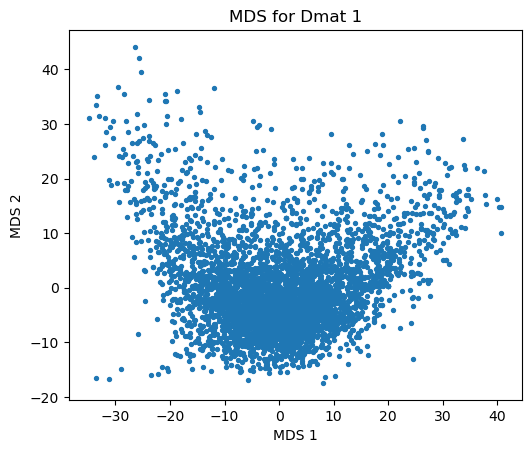

In [39]:
### For dmat1
X1, eigvals = metric_mds(Dmat1, n_components = 2)
plt.scatter(X1[:,0], X1[:,1], s=8)
plt.xlabel('MDS 1'); plt.ylabel('MDS 2'); plt.title('MDS for Dmat 1')
plt.gca().set_aspect('equal')
plt.show()

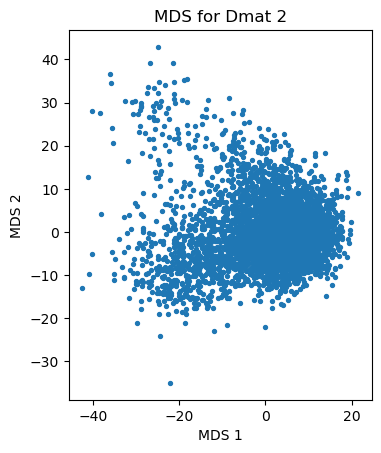

In [38]:
### For dmat2
X2, eigvals = metric_mds(Dmat2, n_components = 2)
plt.scatter(X2[:,0], X2[:,1], s=8)
plt.xlabel('MDS 1'); plt.ylabel('MDS 2'); plt.title('MDS for Dmat 2')
plt.gca().set_aspect('equal')
plt.show()

#### MDS for DMAT 1 looks close to the PCA of the Ecoli matrix 
#### MDS for DMAT 2 looks close to the PCA of the Bacillus matrix 

#### I will be using the labels respectively

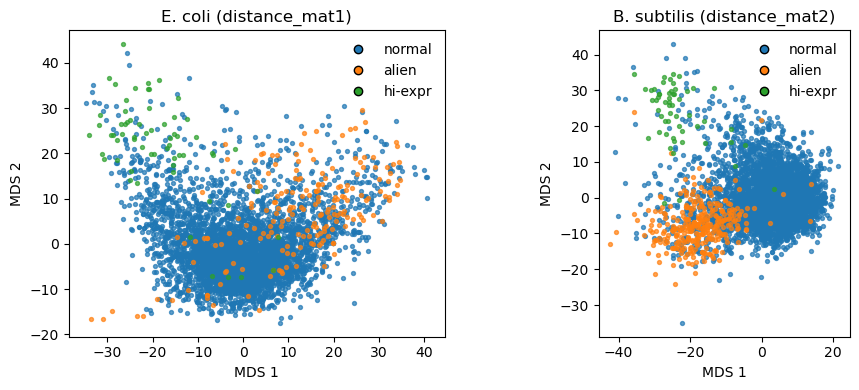

In [41]:
# Renaming the matrices and labels
D_ecoli = np.load("distance_mat1.npy")      
lab_ecoli = np.loadtxt("EcoliRSCU.label.csv", delimiter =",",  dtype=int)  

D_bsub  = np.load("distance_mat2.npy")      
lab_bsub = np.loadtxt("BsubRSCU.label.csv", delimiter =",",    dtype=int)

#Colour map and helper for the legend
palette  = {0:"#1f77b4", 1:"#ff7f0e", 2:"#2ca02c"}  # blue / orange / green
names    = {0:"normal", 1:"alien", 2:"hi-expr"}

def make_legend(ax):
    handles = [Line2D([0], [0], marker="o", ls="",
                      color=palette[k], label=names[k], mec="k", ms=6)
               for k in sorted(palette)]
    ax.legend(handles=handles, frameon=False)

# Plotting the scatter plots side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=False, sharey=False)

# Ecoli
ax = axs[0]
for k in np.unique(lab_ecoli):
    mask = lab_ecoli == k
    ax.scatter(X1[mask, 0], X1[mask, 1],
               c=palette[k], s=8, alpha=0.7)
ax.set_title("E. coli (distance_mat1)")
ax.set_xlabel("MDS 1"); ax.set_ylabel("MDS 2")
ax.set_aspect("equal")
make_legend(ax)

# Bsub
ax = axs[1]
for k in np.unique(lab_bsub):
    mask = lab_bsub == k
    ax.scatter(X2[mask, 0], X2[mask, 1],
               c=palette.get(k, "#7f7f7f"), s=8, alpha=0.7)
ax.set_title("B. subtilis (distance_mat2)")
ax.set_xlabel("MDS 1"); ax.set_ylabel("MDS 2")
ax.set_aspect("equal")
make_legend(ax)

plt.tight_layout()
plt.show()
